![logo](./img/LogoLine_horizon_C3S.png)

# Looking at Sea Level data during an El Niño episode

This notebook-tutorial provides a practical introduction to the Sea level gridded data from satellite observations for the global ocean from 1993 to present data 
<br>
We give a short introduction to the ECV Earth Radiation Budget, Outgoing Longwave Radiation (OLR) and provide three use cases of the dataset: plot the time-averaged global distribution of OLR (Use Case 1), calculate global timeseries of OLR (Use Case 2) and plot the Arctic weighted mean timeseries between 1979 and 2019 (Use Case 3).
We provide step-by-step instructions on data preparation. Use cases come with extensive documentation and each line of code is explained.  
Two figures below are results of Use Case 1 and 2, and the result of a successful run of the code.

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-c3s/blob/main/ecv-notebooks/erb-outgoing-longwave-radiation.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-c3s/main?labpath=ecv-notebooks/erb-outgoing-longwave-radiation.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-c3s/blob/main/ecv-notebooks/erb-outgoing-longwave-radiation.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

<br><br>


## 2. Prerequisites and data preparations

This chapter provides information on how to: run the notebook, lists necessary python libraries, and guides you through the process of data on data preparation: how to download the data via CDS API, and get it ready to be used.

### 2.1 How to access the notebook

This tutorial is in the form of a [Jupyter notebook](https://jupyter.org/). You will not need to install any software for the training as there are a number of free cloud-based services to create, edit, run and export Jupyter notebooks such as this. Here are some suggestions (simply click on one of the links below to run the notebook):

We are using `cdsapi` to download the data. This package is not yet included by default on most cloud platforms. You can use `pip` to install it:


```!pip install cdsapi```  


**Run the tutorial in local environment**  
If you would like to run this notebook in your own environment, we suggest you install [Anaconda](https://docs.anaconda.com/anaconda/install/), which is the easiest way to get all libraries installed.  

In this case, you can install the CDS API by using `conda` :<br>
```!conda install cdsapi```  
<br>
We will be working with data in NetCDF format. To best handle NetCDF data we will use libraries for working with multidimensional arrays, in particular  [Xarray](http://xarray.pydata.org/en/stable/). We will also need libraries for plotting and viewing data, in this case, we will use [Matplotlib](https://matplotlib.org/stable/index.html) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/). [urllib3](https://urllib3.readthedocs.io/en/stable/) for disabling warnings for data download via CDS API.

### 2.2 Import libraries

In [1]:
# CDS API library
import cdsapi

# Libraries for working with multidimensional arrays
import xarray as xr
import numpy as np

# Library to work with zip-archives, OS-functions and pattern expansion
import zipfile
import os

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Disable warnings for data download via API
import urllib3
urllib3.disable_warnings()


### 2.3 Download data using CDS API

This subsection describes the process of data search in the CDS catalogue, and data preparation for use in the use cases.

#### Set up CDS API credentials

We will request data from the CDS programmatically with the help of the [CDS API](https://confluence.ecmwf.int/display/CKB/Climate+Data+Store+%28CDS%29+infrastructure+and+API).  

We have defined our credentials in a .cdsapirc file put in our user folder (users/name under windows,  $HOME/ under linux). When connecting to the page (https://cds-beta.climate.copernicus.eu/how-to-api) (having an account on the CDS), you'll have your key to copy-paste in the file





In [2]:
DATADIR = 'datacds/'
os.makedirs(DATADIR, exist_ok=True)
# Filename for the zip file downloaded from the CDS
downloaded_zipfile = os.path.join(DATADIR, 'dataset-satellite-sea-level-global_monthly.zip')

We start by downloading a monthly file from 2015/11, using the latest version of the data available as of this day (vDT2021)

In [3]:
dataset = "satellite-sea-level-global"
request = {
    'variable': ['monthly_mean'],
    'year': ['2015'],
    'month': ['11'],
    'version': 'vdt2021'
}

client = cdsapi.Client()
client.retrieve(dataset, request, downloaded_zipfile)

2024-09-30 11:34:42,198 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-09-30 11:34:42,204 WARNING [2024-09-26T00:00:00] Should you have not yet migrated from the old CDS system to the new CDS, please check our [informative page](https://confluence.ecmwf.int/x/uINmFw) for guidance.
2024-09-30 11:34:42,205 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-09-30 11:34:42,206 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-09-30 11:34:42,208 WARNING [2024-06-16T

'datacds/dataset-satellite-sea-level-global_monthly.zip'

In [4]:
with zipfile.ZipFile(downloaded_zipfile, 'r') as zip_ref:
    filelist = [os.path.join(DATADIR, f) for f in zip_ref.namelist()]
    zip_ref.extractall(DATADIR)

# Ensure the filelist is in the correct order:
filelist = sorted(filelist)

# Merge all unpacked files into one (if more than one file) - here we have only one
ds = xr.open_mfdataset(filelist, concat_dim='time', combine='nested')


## 3. Use Cases



### **Use case 1**: explore and plot a monthly file

Firstly, we should get an overview of the parameter by plotting the time-averaged global distribution. 
The data are stored in NetCDF format, and we will use Xarray library to work with the data. 
We will then use Matplotlib and Cartopy to visualise the data.

NetCDF is a self-described format, i.e. it includes information ("metadata") to help describe and explain the data, such as explicit name (long_name), standardized name (standard_name), comment, units, min and max values, also default value, etc. Those information are called "attributes", and are specific to the file, or to each variable; they are mostly optional, but highly recommended; the "standardization" of the format makes some of them mandatory. It is part of the CMEMS requirements. 

We will print the list of variables defined within the file. 

In [5]:
ds.data_vars

Data variables:
    crs               (time) int32 4B -2147483647
    climatology_bnds  (time, nv) datetime64[ns] 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds          (time, latitude, nv) float32 6kB dask.array<chunksize=(1, 50, 2), meta=np.ndarray>
    lon_bnds          (time, longitude, nv) float32 12kB dask.array<chunksize=(1, 50, 2), meta=np.ndarray>
    sla               (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    eke               (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>

## 3. Read and load a data variable for monthly Product: Sea Level Anomalies

<div class="alert alert-block alert-success">
<b>Objective</b>

***  
We will read the Sea Level Anomalies variable.
</div>  

If you had a look at the standard names, you have seen that this is also called "sea_surface_height_above_sea_level"; 

Acronyms used below:
- <b>SLA</b> Sea Level Anomaly  (sea surface height with respect to a mean sea surface); it represents ocean variability
- <b>ADT</b> Absolute Dynamic Topography  (sea surface height with respect to the geoid); it represents the heights linked to everything moving in the ocean
- <b>MSS</b> Mean Sea Surface (a multi-year average of the sea surface heights with respect to a reference ellipsoid -- MSS is not provided here)
- <b>MDT</b> Mean Dynamic Topography : ADT = SLA + MDT ; MDT is obtained through MSS - geoid and also drifter current velocity analysis. It represents the heights linked to the mean stable currents. It is now provided through CMEMS as another dataset.
- <b>EKE</b> Eddy Kinetic Energy: the kinetic energy computed from the geostrophic currents derived from the slope of the sea level anomalies.

(NB. the reference ellipsoid is a geometric surface approximating Earth surface ; the geoid is an equipotential of the Earth gravity field)

![](./images/names-heights.png)


In [6]:
# we subset the initial dataset at this date in SeaLevelAnom using sel (for "selection")
# note that in the provided file you only have one date. 
SeaLevelAnom = ds['sla'][0]
# Finally, we upload and store the latitude and longitude so as to be able to call them later on
latitude = ds['latitude']
longitude = ds['longitude']

## 4. Plot the Data

### 4.1. Plot the monthly data for Sea Level Anomaly for Nov. 2015

We will plot the Sea Level Anomalies in a "plate carree" projection (scale: longitude = latitude), see https://scitools.org.uk/cartopy/docs/latest/crs/projections.html.

We are keeping the default color scale minimum and maximum (i.e. the minimum and maximum value of the variable within the given file -- it could be different on another day).
The lands are colored in grey (lightgrey) and delimited by a 1-px line. 
We set the extent of the plot using the maximum and minimum longitude and latitude defined above. 
We add a color scale (colorbar), and a title; here we put the unit of the scale in the title, in a 16-size font.

In [7]:
lon_min=-180. ; lon_max=180. ; lat_min=-90. ; lat_max=90.

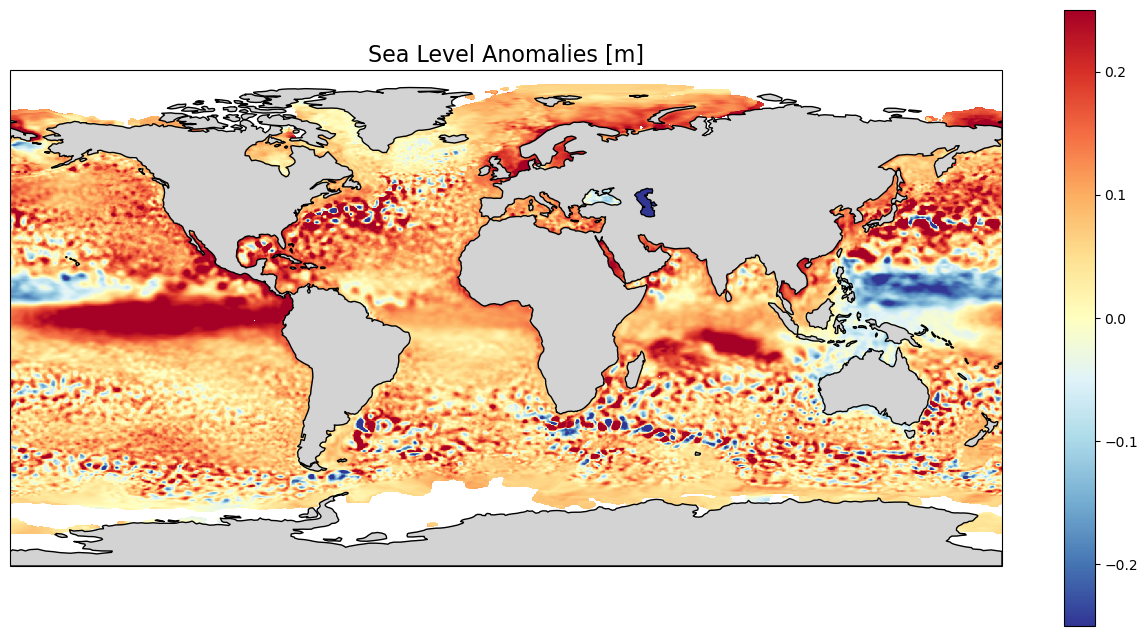

In [10]:
# Create python object from the "matplotlib" and its "pyplot" package (shortened as plt)
plt.figure(figsize=(16, 8))
# Create an "ax" from which we add the projection
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
# Add a layer for the continent
ax.add_feature(cfeature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=1)
# Set the extent of the map.
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
# Define a colormesh which is the color plot
mymap = ax.pcolormesh(longitude, latitude, SeaLevelAnom, vmin=-0.25, vmax=0.25, cmap='RdYlBu_r', transform=ccrs.PlateCarree(central_longitude=0.), zorder=0)
# Add a colorbar to the map object to give scale
plt.colorbar(mymap, ax=ax)
# Add a title to the map object
plt.title('Sea Level Anomalies [m]', size=16)
plt.show()

Center the map on the Pacific to better see what is happening there

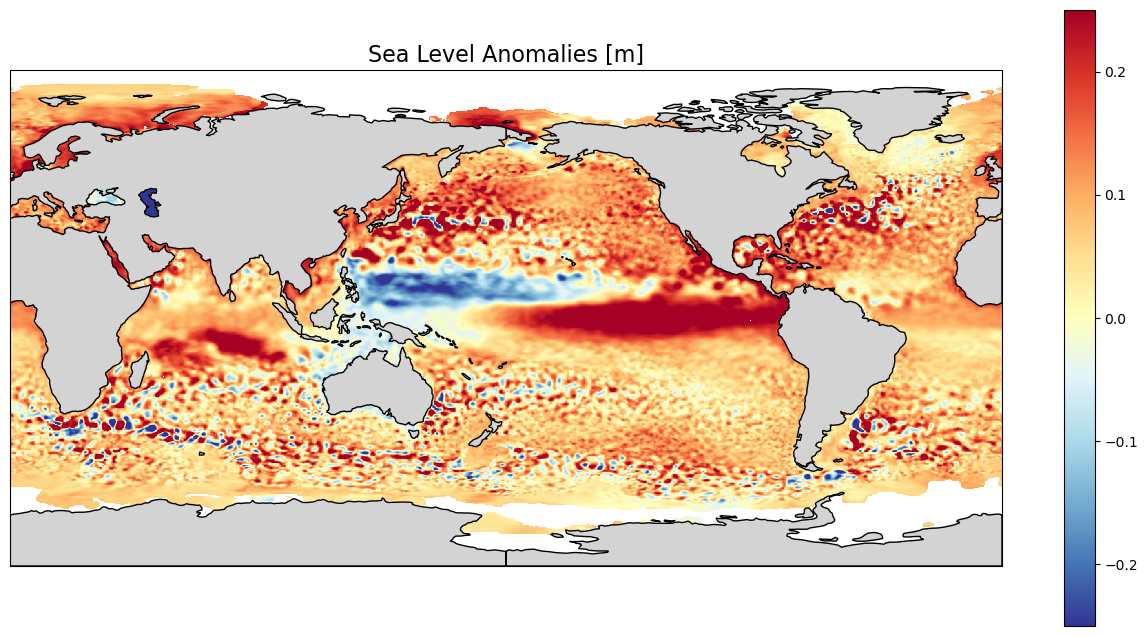

In [12]:
# Create python object from the "matplotlib" and its "pyplot" package (shortened as plt)
plt.figure(figsize=(16, 8))
# Create an "ax" from which we add the projection of the plot (here we make it centered on 180°E)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180.))
# Add a layer for the continent - we place it over the ocean data using a "zorder" higher than for the data (resulting map is neater, it is not essential)
ax.add_feature(cfeature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=1)
# Set the extent of the map.
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
# Define a colormesh which is the color plot; note that the projection indicated is the projection of the data themselves
mymap = ax.pcolormesh(longitude, latitude, SeaLevelAnom, vmin=-0.25, vmax=0.25, cmap='RdYlBu_r', transform=ccrs.PlateCarree(central_longitude=0.), zorder=0)
# Add a colorbar to the map object to give scale
plt.colorbar(mymap, ax=ax)
# Add a title to the map object
plt.title('Sea Level Anomalies [m]', size=16)
plt.show()

We see here the higher-than-average  sea level anomalies in the Eastern Tropical Pacific which is one of the signature of an El Niño episode (counterbalanced by lower-than-average sea level anomalies in the Western Pacific). If we look at the previous months, we will see this anomaly crossing the whole Pacific, from West to East, from Asia to South America. 
Red and blue 'dots', mostly concentrated in the major current areas (Gulf Stream, Antarctic Circumpolar Current, Kuroshio...) are strong mesoscale eddies, anticyclonic for "red" dots (higher-than-average sea level anomalies, also warm eddies), cyclonic for "blue" dots (lower-than-average sea level anomalies, also cold eddies). Some of those are present in this monthly average since they typically last for more than 30 days (they are moving, though, during such period). These eddies are an important part of vertical mixing of the ocean, and have thus a role in climate processes.

We will have a look at the daily data, and the signature of those eddies in both Sea Level Anomalies and geostrophic current velocities in a strong current (let's say: the Gulf Stream)

## 3. Read and load a data variable for daily Product

In [13]:
# Filename for the zip file downloaded from the CDS
downloaded_zipfiledaily = os.path.join(DATADIR, 'dataset-satellite-sea-level-global_daily.zip')

mydate = "20230908"

In [14]:
dataset = "satellite-sea-level-global"
request = {
    'variable': ['daily'],
    'year': ['2023'],
    'month': ['09'],
    'day': ['08'],
    'version': 'vdt2021'
}
client = cdsapi.Client()
client.retrieve(dataset, request, downloaded_zipfiledaily)

2024-09-30 11:38:22,040 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-09-30 11:38:22,042 WARNING [2024-09-26T00:00:00] Should you have not yet migrated from the old CDS system to the new CDS, please check our [informative page](https://confluence.ecmwf.int/x/uINmFw) for guidance.
2024-09-30 11:38:22,043 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-09-30 11:38:22,044 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-09-30 11:38:22,045 WARNING [2024-06-16T

'datacds/dataset-satellite-sea-level-global_daily.zip'

In [15]:
with zipfile.ZipFile(downloaded_zipfiledaily, 'r') as zip_ref:
    filelist = [os.path.join(DATADIR, f) for f in zip_ref.namelist()]
    zip_ref.extractall(DATADIR)

# Ensure the filelist is in the correct order:
filelistdaily = sorted(filelist)

# Merge all unpacked files into one (if more than one file) - here we have only one
dsdaily = xr.open_mfdataset(filelistdaily, concat_dim='time', combine='nested')

In [16]:
dsdaily.data_vars

Data variables:
    crs             (time) int32 4B -2147483647
    lat_bnds        (time, latitude, nv) float32 6kB dask.array<chunksize=(1, 50, 2), meta=np.ndarray>
    lon_bnds        (time, longitude, nv) float32 12kB dask.array<chunksize=(1, 50, 2), meta=np.ndarray>
    sla             (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    err_sla         (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    ugosa           (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    err_ugosa       (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    vgosa           (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    err_vgosa       (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    adt             (time, latitude, longitude) float64 8MB da

In the case of daily data, the EKE is not pre-computed, but you do have U and V components of the geostrophic velocity derived from the Sea Level Anomalies (ugosa, vgosa). You also have the absolute dynamic topography (ADT) and also the corresponding geostrophic velocities (ugos, vgos). Let's have a look at all those, and compute a EKE from them, too, over the Gulf Stream area.

In [17]:
# the area of study: North-West Atlantic 
lon_min=-85. ; lon_max=-30. ; lat_min=15. ; lat_max=55.

Select only the area and save the dataset thus created in a netcdf file for future uses.

In [18]:
# We select the part of the dataset included between the maximum and minimum longitude (resp. latitude)
# as if we were cutting a slice of the data.
# pcolor mesh interpolate, so you can add half a step in every direction (or you'll have a blank line all around your plot)
step = 0.25/2.
extrds = dsdaily.sel(longitude=slice(lon_min-step, lon_max+step), latitude=slice(lat_min-step, lat_max+step))
dsdaily.close()

# Save the geographical subset into a new NetCDF file, using 'to_netcdf' for this
# we name the file BS_2019-09-01.nc, using the date defined ealier. 
output_filename = 'gulfstream_'+mydate+'.nc'
extrds.to_netcdf( os.path.join(DATADIR, output_filename))

Load the different sea surface height-related variables. First, plot the sea level anomalies (as for the monthly file) over our area of interest.

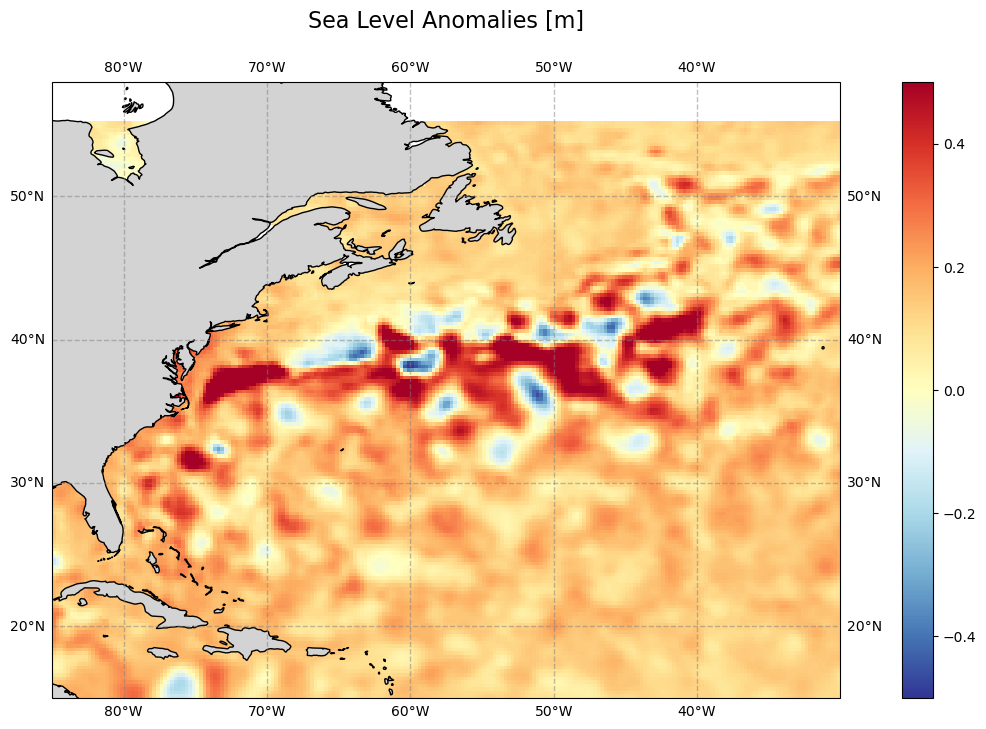

In [20]:
adt = extrds['adt'].sel(time=mydate)
uadt = extrds['ugos'].sel(time=mydate)
vadt = extrds['vgos'].sel(time=mydate)
uvadt = np.sqrt(uadt**2 + vadt**2)
sla = extrds['sla'].sel(time=mydate)
usla = extrds['ugosa'].sel(time=mydate)
vsla = extrds['vgosa'].sel(time=mydate)
uvsla = np.sqrt(usla**2 + vsla**2)

latitude = extrds['latitude']
longitude = extrds['longitude']

plt.figure(figsize=(16, 8))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180.))
# Add a layer for the continent - we place it over the ocean data using a "zorder" higher than for the data (resulting map is neater, it is not essential)
ax.add_feature(cfeature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=1)
# Set the extent of the map.
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
ax.gridlines(crs=ccrs.PlateCarree(central_longitude=0), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
# actually plot the data
mymap = ax.pcolormesh(longitude, latitude, sla, cmap='RdYlBu_r', vmin=-0.5, vmax=0.5, transform=ccrs.PlateCarree(central_longitude=0), zorder=0)
plt.colorbar(mymap, ax=ax)
plt.title('Sea Level Anomalies [m]', size=16, pad=24)
plt.show()


Plot all the variables loaded and computed, absolute dynamic topography (left) and anomalies (right), side by side.

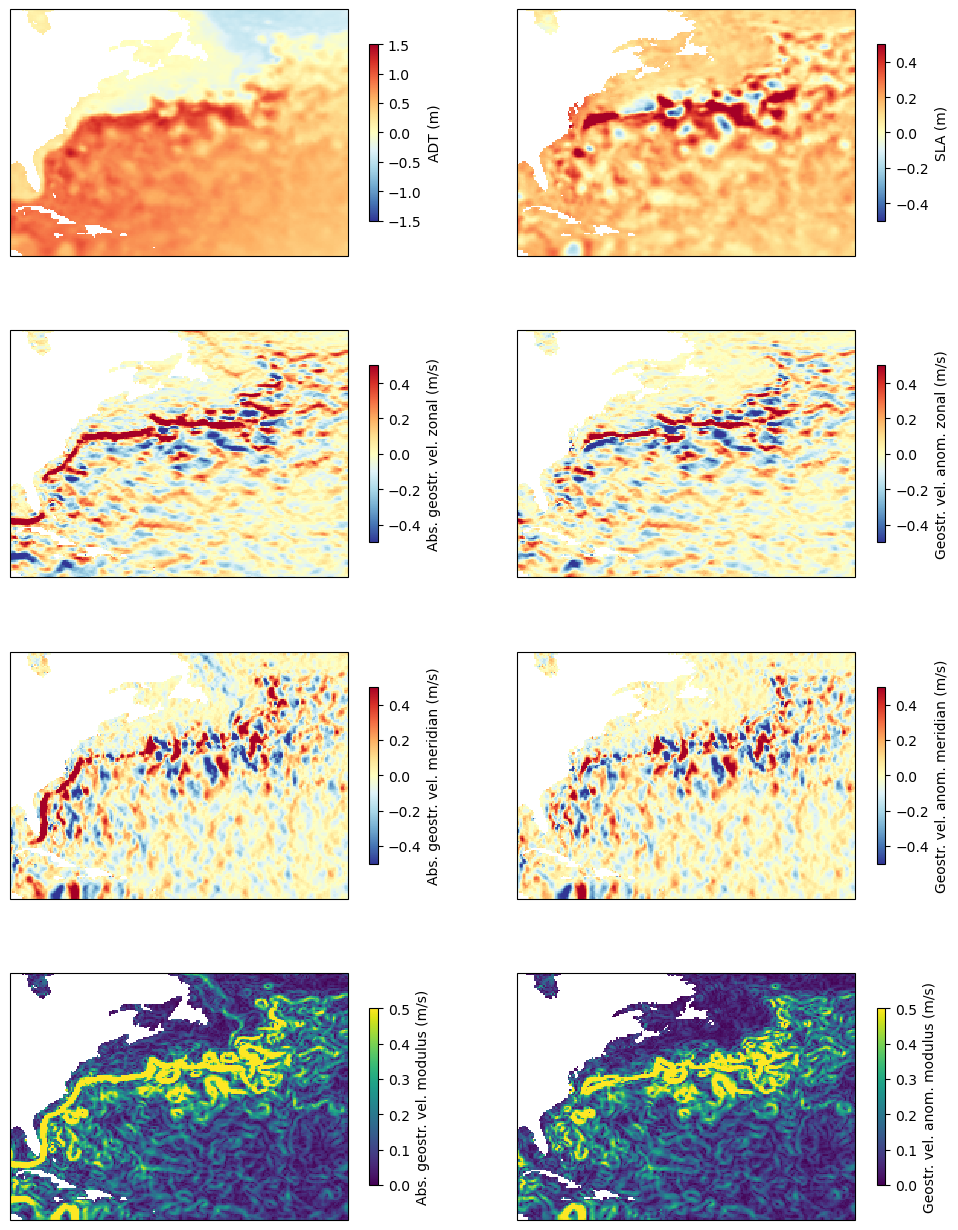

In [22]:
fig, axs = plt.subplots(nrows=4,ncols=2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)}, figsize=(12,16))

fadt = axs[0, 0].pcolormesh(longitude, latitude, adt, cmap='RdYlBu_r', vmin=-1.5, vmax=1.5, transform=ccrs.PlateCarree(central_longitude=0))
fsla = axs[0, 1].pcolormesh(longitude, latitude, sla, cmap='RdYlBu_r', vmin=-0.5, vmax=0.5, transform=ccrs.PlateCarree(central_longitude=0))
fuadt = axs[1, 0].pcolormesh(longitude, latitude, uadt, cmap='RdYlBu_r', vmin=-0.5, vmax=0.5, transform=ccrs.PlateCarree(central_longitude=0))
fusla = axs[1, 1].pcolormesh(longitude, latitude, usla, cmap='RdYlBu_r', vmin=-0.5, vmax=0.5, transform=ccrs.PlateCarree(central_longitude=0))
fvadt = axs[2, 0].pcolormesh(longitude, latitude, vadt, cmap='RdYlBu_r', vmin=-0.5, vmax=0.5, transform=ccrs.PlateCarree(central_longitude=0))
fvsla = axs[2, 1].pcolormesh(longitude, latitude, vsla, cmap='RdYlBu_r', vmin=-0.5, vmax=0.5, transform=ccrs.PlateCarree(central_longitude=0))
fceladt = axs[3, 0].pcolormesh(longitude, latitude, uvadt, vmin=0, vmax=0.5, cmap='viridis', transform=ccrs.PlateCarree(central_longitude=0))
fcelsla = axs[3, 1].pcolormesh(longitude, latitude, uvsla, vmin=0, vmax=0.5, cmap='viridis', transform=ccrs.PlateCarree(central_longitude=0))

fig.colorbar(fadt, ax=axs[0, 0], shrink=0.66, label="ADT (m)")
fig.colorbar(fsla, ax = axs[0, 1], shrink=0.66, label="SLA (m)")
fig.colorbar(fuadt, ax = axs[1, 0], shrink=0.66, label="Abs. geostr. vel. zonal (m/s)")
fig.colorbar(fusla, ax = axs[1, 1], shrink=0.66, label="Geostr. vel. anom. zonal (m/s)")
fig.colorbar(fvadt, ax = axs[2, 0], shrink=0.66, label="Abs. geostr. vel. meridian (m/s)")
fig.colorbar(fvsla, ax = axs[2, 1], shrink=0.66, label="Geostr. vel. anom. meridian (m/s)")
fig.colorbar(fceladt, ax = axs[3, 0], shrink=0.66, label="Abs. geostr. vel. modulus (m/s)")
fig.colorbar(fcelsla, ax = axs[3, 1], shrink=0.66, label="Geostr. vel. anom. modulus (m/s)")


The top row show the sea surface heights (ADT) with respect to the geoid. One can see the "hill" (at North Atlantic basin's scale) which is the Gulf Stream gyre, around which the Gulf Stream system turn, clockwise. The first column show the ADT and derived geostrophic velocities - U (i.e. eastward component) and V (i.e. Northward component), and the computation sqrt(U^2 + V^2), i.e. the current modulus. The second column shows the anomalies (notice the change in color bar minimum & maximum between ADT and SLA). A large part is similar than in ADT since, in such an energetic current, turbulence constitute a major part of the dynamic, so eddies are of strong amplitude and clearly visible even upon the main flow of the current. But in the bottom map the main Gulf Stream flow is visible left, as a large line coming from the Gulf of Mexico and continuing north-eastwards, while "only" rings and meanders are visible in the right map.